## MT3DMS Problem 2

This is the second example problem presented in Zheng 1999, titled "One-dimensional transport
with nonlinear or nonequilibrium sorption. The purpose of this example is to demonstrate
simulation of nonlinear and nonequilibrium sorption. In this section the results from the
GWT model are compared with the results from MT3DMS.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwt-mt3dms-p02"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from an environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Scenario parameters - make sure there is at least one blank line before next item
parameters = {
    "ex-gwt-mt3dms-p02a": {
        "sorption": "freundlich",
        "Kf": 0.3,
        "a": 0.7,
    },
    "ex-gwt-mt3dms-p02b": {
        "sorption": "langmuir",
        "Kl": 100.0,
        "S": 0.003,
    },
    "ex-gwt-mt3dms-p02c": {
        "beta": 0.0,
    },
    "ex-gwt-mt3dms-p02d": {
        "beta": 0.002,
    },
    "ex-gwt-mt3dms-p02e": {
        "beta": 0.01,
    },
    "ex-gwt-mt3dms-p02f": {
        "beta": 20.0,
    },
}

# Scenario parameter units - make sure there is at least one blank line before next item
# add parameter_units to add units to the scenario parameter table
parameter_units = {
    "beta": "$s^{-1}$",
    "sorption": "text string",
    "Kf": r"$\mu g L g^{} mg^{-1}$",
    "a": "unitless",
    "Kl": "$L mg^{-1}$",
    "S": r"$\mu g g^{-1}$",
}

# Model units
length_units = "centimeters"
time_units = "seconds"

# Model parameters
nper = 2  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 101  # Number of columns
period1 = 160  # Length of period 1 ($s$)
period2 = 1340  # Length of period 2 ($s$)
delta_time = 1.0  # Length of time steps ($s$)
delr = 0.16  # Column width ($cm$)
delc = 0.16  # Row width ($cm$)
top = 1.0  # Top of the model ($cm$)
botm = 0  # Layer bottom elevation ($cm$)
velocity = 0.1  # Velocity ($cm s^{-1}$)
hydraulic_conductivity = 0.01  # Hydraulic conductivity ($cm s^{-1}$)
porosity = 0.37  # Porosity of mobile domain (unitless)
bulk_density = 1.587  # Bulk density ($g cm^{-3}$)
distribution_coefficient = 0.933  # Distribution coefficient ($cm^3 g^{-1}$)
dispersivity = 1.0  # Longitudinal dispersivity ($cm$)
source_concentration = 0.05  # Source concentration (unitless)
initial_concentration = 0.0  # Initial concentration (unitless)

specific_discharge = velocity * porosity
inflow_rate = specific_discharge * delc * (top - botm)
system_length = ncol * delr

# ### Model setup
#
# Define functions to build models, write input files, and run the simulation.

In [3]:
def build_mf6gwf(sim_folder):
    print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = (
        (period1, int(period1 / delta_time), 1.0),
        (period2, int(period2 / delta_time), 1.0),
    )
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    htol = 1.0e-8
    flopy.mf6.ModflowIms(
        sim, print_option="summary", outer_dvclose=htol, inner_dvclose=htol
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    wel_spd = {
        0: [
            [
                (0, 0, 0),
                inflow_rate,
                source_concentration,
            ]
        ],
        1: [
            [
                (0, 0, 0),
                inflow_rate,
                0.0,
            ]
        ],
    }
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        pname="WEL-1",
        auxiliary=["CONCENTRATION"],
    )
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def build_mf6gwt(
    sim_folder, sorption=None, Kf=None, a=None, Kl=None, S=None, beta=None
):
    print(f"Building mf6gwt model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwt")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = (
        (period1, int(period1 / delta_time), 1.0),
        (period2, int(period2 / delta_time), 1.0),
    )
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    ctol = 1.0e-8
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        print_option="summary",
        outer_dvclose=ctol,
        inner_dvclose=ctol,
    )
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=initial_concentration)
    distcoef = None
    if Kf is not None:
        distcoef = Kf
    if Kl is not None:
        distcoef = Kl
    sp2 = None
    if a is not None:
        sp2 = a
    if S is not None:
        sp2 = S
    volfracim = 0.0
    if beta is not None:
        if beta > 0:
            volfracim = bulk_density / (bulk_density + porosity)

    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity / (1.0 - volfracim),
        bulk_density=bulk_density if sorption else None,
        sorption=sorption,
        distcoef=distcoef,
        sp2=sp2,
    )
    flopy.mf6.ModflowGwtadv(gwt, scheme="UPSTREAM")
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, alh=dispersivity, ath1=dispersivity)
    if beta is not None:
        if beta > 0:
            porosity_im = bulk_density / volfracim
            flopy.mf6.ModflowGwtist(
                gwt, volfrac=volfracim, porosity=porosity_im, zetaim=beta
            )
    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
    sourcerecarray = [["WEL-1", "AUX", "CONCENTRATION"]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    obs_data = {
        f"{name}.obs.csv": [
            ("X008", "CONCENTRATION", (0, 0, 50)),
        ],
    }
    obs_package = flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, continuous=obs_data
    )
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{name}.cbc",
        concentration_filerecord=f"{name}.ucn",
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    return sim


def build_mf2005(sim_folder):
    print(f"Building mf2005 model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf2005")
    mf = flopy.modflow.Modflow(modelname=name, model_ws=sim_ws, exe_name="mf2005")
    perlen = [period1, period2]
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        nper=nper,
        perlen=perlen,
    )
    bas = flopy.modflow.ModflowBas(mf)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hydraulic_conductivity)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)

    chdspd = [[0, 0, ncol - 1, 1.0, 1.0]]
    chd = flopy.modflow.ModflowChd(mf, stress_period_data=chdspd)

    q = inflow_rate
    welspd = [[0, 0, 0, q]]
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    return mf


def build_mt3dms(
    sim_folder,
    modflowmodel,
    sorption=None,
    Kf=None,
    a=None,
    Kl=None,
    S=None,
    beta=None,
):
    print(f"Building mt3dms model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mt3d")
    mt = flopy.mt3d.Mt3dms(
        modelname=name,
        model_ws=sim_ws,
        exe_name="mt3dms",
        modflowmodel=modflowmodel,
        ftlfilename="../mf2005/mt3d_link.ftl",
    )
    dt0 = delta_time
    btn = flopy.mt3d.Mt3dBtn(
        mt, laycon=0, prsity=porosity, dt0=dt0, ifmtcn=1, obs=[(0, 0, 50)]
    )
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=dispersivity)
    if beta is not None:
        isothm = 4
        sp1 = distribution_coefficient
        sp2 = beta
    if Kf is not None:
        isothm = 2
        sp1 = Kf
        sp2 = a
    if Kl is not None:
        isothm = 3
        sp1 = Kl
        sp2 = S
    rct = flopy.mt3d.Mt3dRct(
        mt, isothm=isothm, igetsc=0, rhob=bulk_density, sp1=sp1, sp2=sp2
    )

    ssmspd = {}
    ssmspd[0] = [[0, 0, 0, source_concentration, 2]]
    ssmspd[1] = [[0, 0, 0, 0.0, 2]]
    ssm = flopy.mt3d.Mt3dSsm(mt, mxss=2, stress_period_data=ssmspd)
    gcg = flopy.mt3d.Mt3dGcg(mt, cclose=1.0e-8)
    return mt


def build_models(sim_name, **kwargs):
    sim_mf6gwf = build_mf6gwf(sim_name)
    sim_mf6gwt = build_mf6gwt(sim_name, **kwargs)
    sim_mf2005 = build_mf2005(sim_name)
    sim_mt3dms = build_mt3dms(sim_name, sim_mf2005, **kwargs)
    return sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms


def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwt.write_simulation(silent=silent)
    sim_mf2005.write_input()
    sim_mt3dms.write_input()


@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    success, buff = sim_mf6gwf.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf6gwt.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf2005.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mt3dms.run_model(
        silent=silent, normal_msg="Program completed", report=True
    )
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (5, 3)


def plot_results_ct(sims, idx, **kwargs):
    print("Plotting C versus t model results...")
    _, sim_mf6gwt, _, sim_mt3dms = sims

    with styles.USGSPlot():
        sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
        mf6gwt_ra = sim_mf6gwt.get_model("trans").obs.output.obs().data
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)

        sim_ws = sim_mt3dms.model_ws
        fname = os.path.join(sim_ws, "MT3D001.OBS")
        mt_ra = sim_mt3dms.load_obs(fname)
        axs.plot(
            mt_ra["time"],
            mt_ra["(1, 1, 51)"] / source_concentration,
            color="k",
            label="MT3DMS",
        )

        axs.plot(
            mf6gwt_ra["totim"],
            mf6gwt_ra["X008"] / source_concentration,
            ls="--",
            color="blue",
            # marker="o",
            # mec="blue",
            # mfc="none",
            # markersize="3",
            label="MODFLOW 6",
        )
        axs.set_ylim(0.0, 1.0)
        if idx == 0:
            axs.set_ylim(0, 0.5)
        if idx == 1:
            axs.set_xlim(0, 500)
        axs.set_xlabel("Time (seconds)")
        axs.set_ylabel("Normalized Concentration (unitless)")
        axs.legend()

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-ct.png"
            fpth = figs_path / fname
            fig.savefig(fpth)


def plot_results():
    with styles.USGSPlot():
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        case_colors = ["blue", "green", "red", "yellow"]
        pkeys = list(parameters.keys())
        for icase, sim_name in enumerate(pkeys[2:]):
            sim_ws = os.path.join(workspace, sim_name)
            beta = parameters[sim_name]["beta"]

            fname = os.path.join(sim_ws, "mf6gwt", "trans.obs.csv")
            mf6gwt_ra = flopy.utils.Mf6Obs(fname).data
            mf6conc = mf6gwt_ra["X008"] / source_concentration
            iskip = 20
            axs.plot(
                mf6gwt_ra["totim"][::iskip],
                mf6conc[::iskip],
                markerfacecolor="None",
                markeredgecolor="k",
                marker="o",
                markersize="3",
                linestyle="None",
            )

            fname = os.path.join(sim_ws, "mt3d", "MT3D001.OBS")
            mt3dms_ra = flopy.mt3d.Mt3dms.load_obs(fname)
            axs.plot(
                mt3dms_ra["time"],
                mt3dms_ra["(1, 1, 51)"] / source_concentration,
                color=case_colors[icase],
                label=f"beta {beta}",
            )

        axs.set_ylim(0, 1)
        axs.set_xlabel("Time (days)")
        axs.set_ylabel("Normalized Concentration (unitless)")
        axs.legend()

        if plot_show:
            plt.show()
        if plot_save:
            fname = f"{example_name}.png"
            fpth = figs_path / fname
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building mf6gwf model...ex-gwt-mt3dms-p02a
Building mf6gwt model...ex-gwt-mt3dms-p02a
Building mf2005 model...ex-gwt-mt3dms-p02a
Building mt3dms model...ex-gwt-mt3dms-p02a


run_models took 2699.25 ms
Plotting C versus t model results...


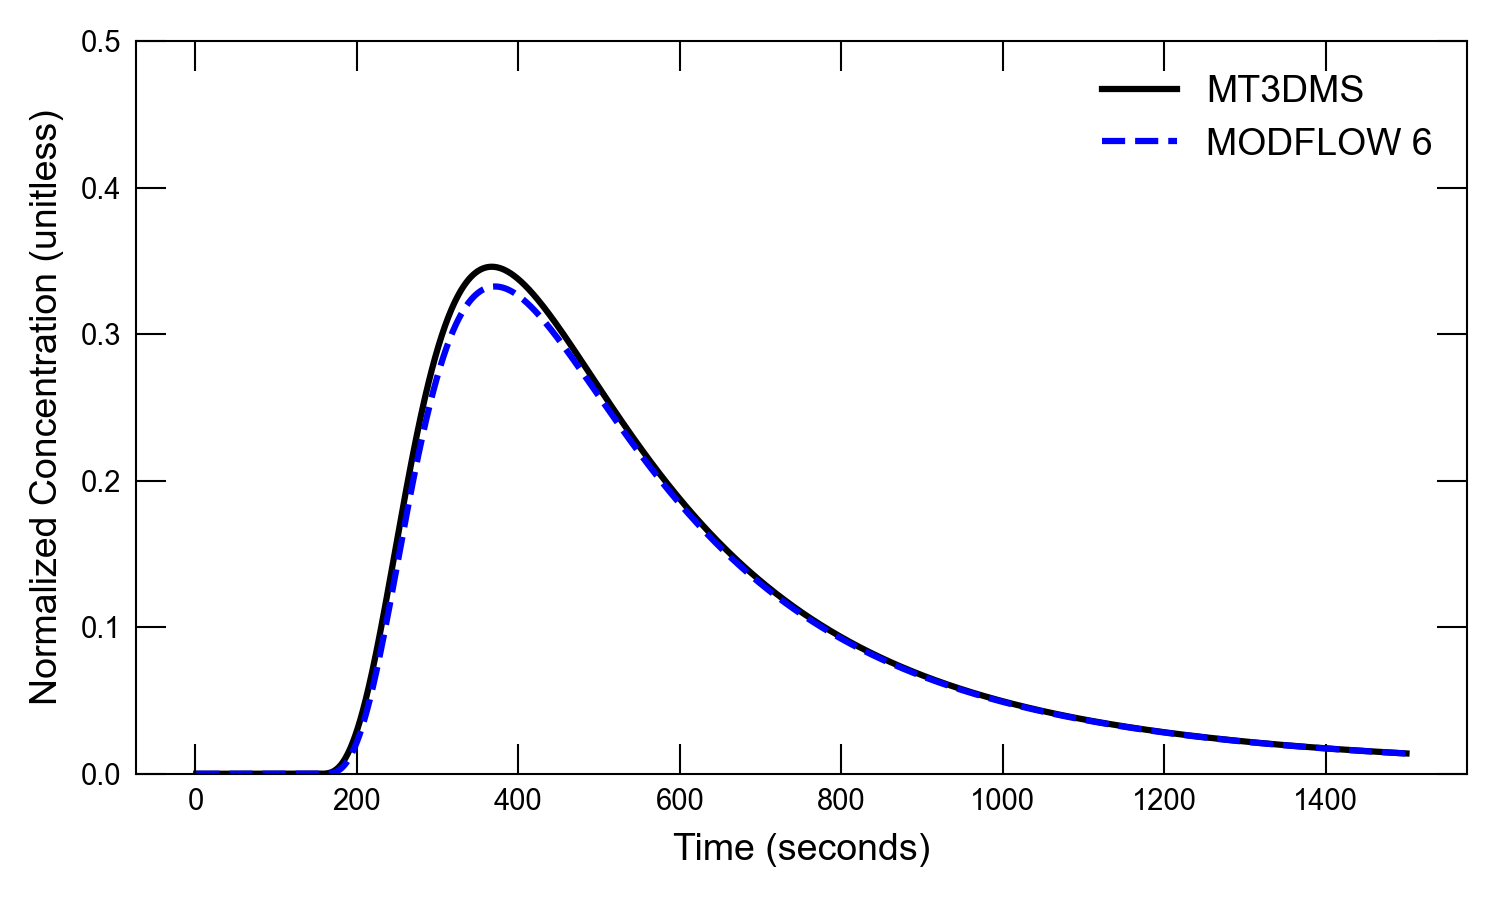

Building mf6gwf model...ex-gwt-mt3dms-p02b
Building mf6gwt model...ex-gwt-mt3dms-p02b
Building mf2005 model...ex-gwt-mt3dms-p02b
Building mt3dms model...ex-gwt-mt3dms-p02b


run_models took 2510.45 ms
Plotting C versus t model results...


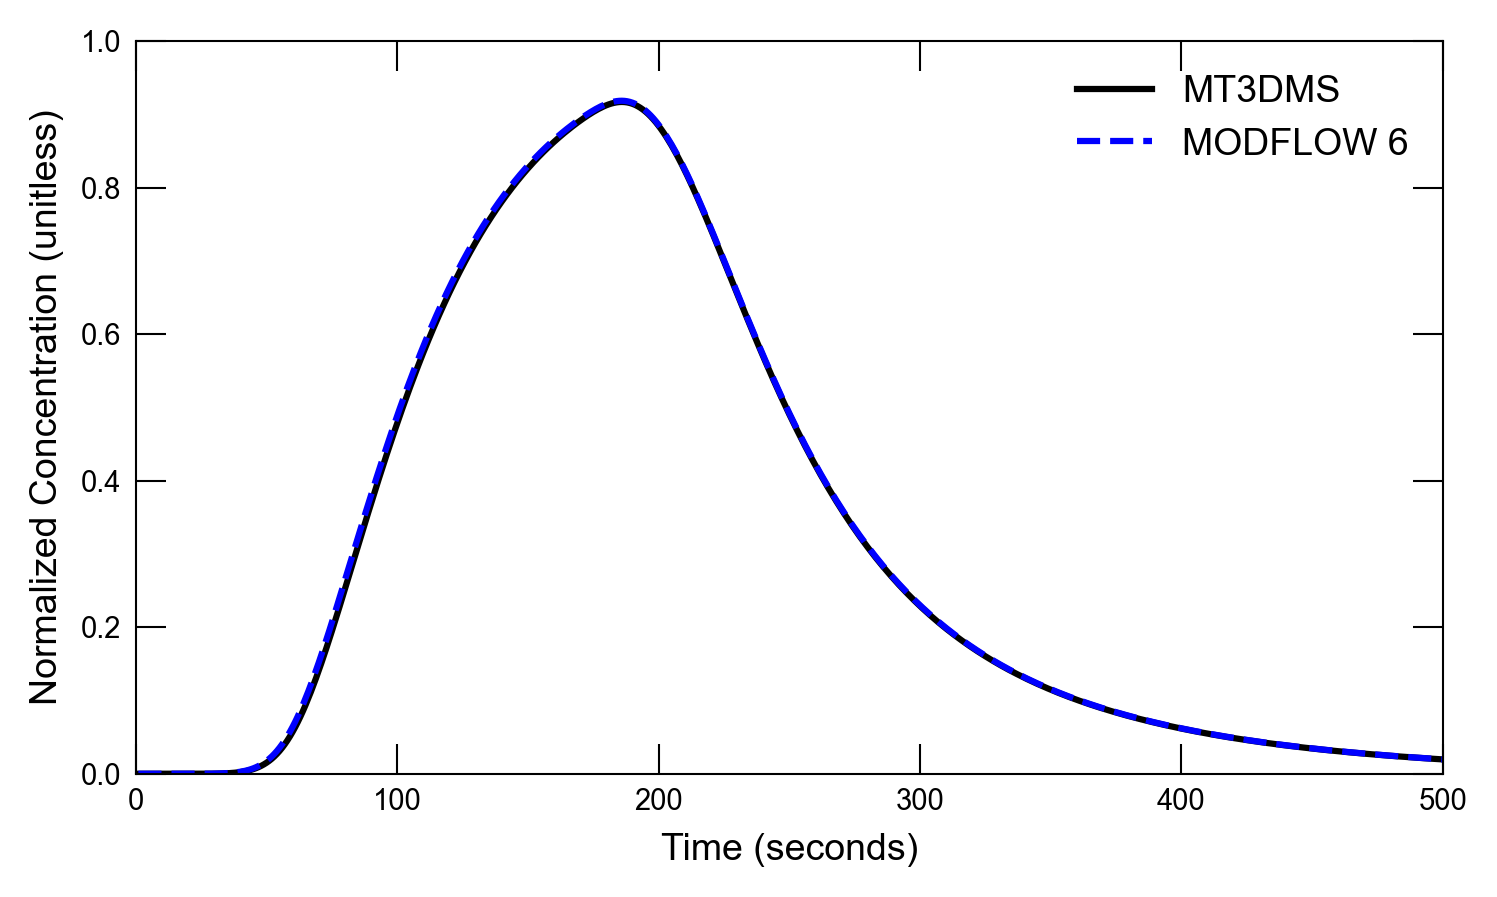

Building mf6gwf model...ex-gwt-mt3dms-p02c
Building mf6gwt model...ex-gwt-mt3dms-p02c
Building mf2005 model...ex-gwt-mt3dms-p02c
Building mt3dms model...ex-gwt-mt3dms-p02c


run_models took 2612.47 ms
Plotting C versus t model results...


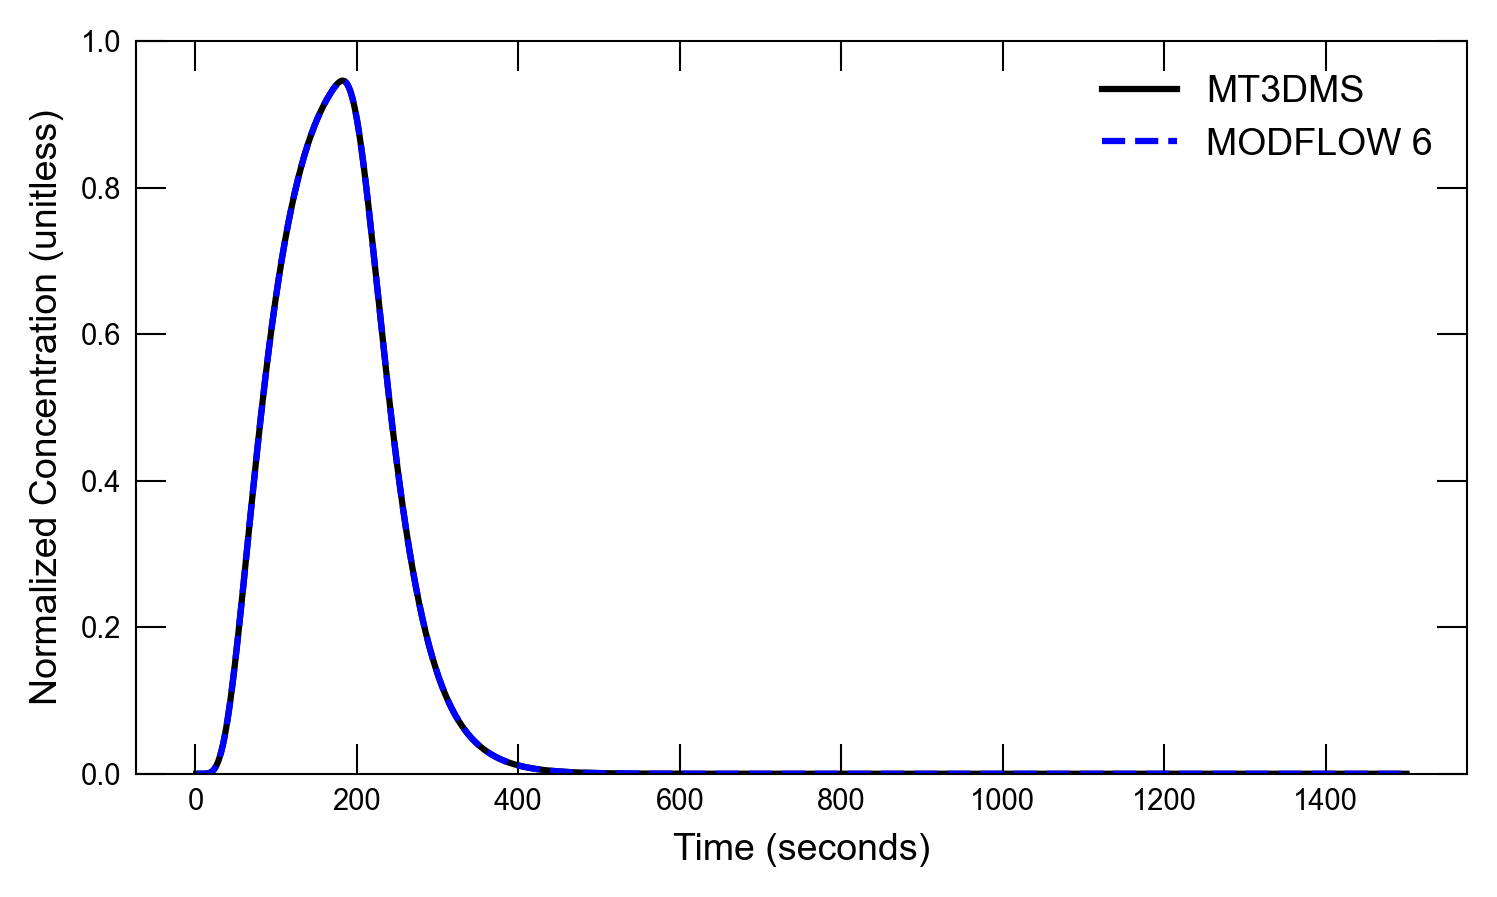

Building mf6gwf model...ex-gwt-mt3dms-p02d
Building mf6gwt model...ex-gwt-mt3dms-p02d
Building mf2005 model...ex-gwt-mt3dms-p02d
Building mt3dms model...ex-gwt-mt3dms-p02d


run_models took 2614.77 ms
Plotting C versus t model results...


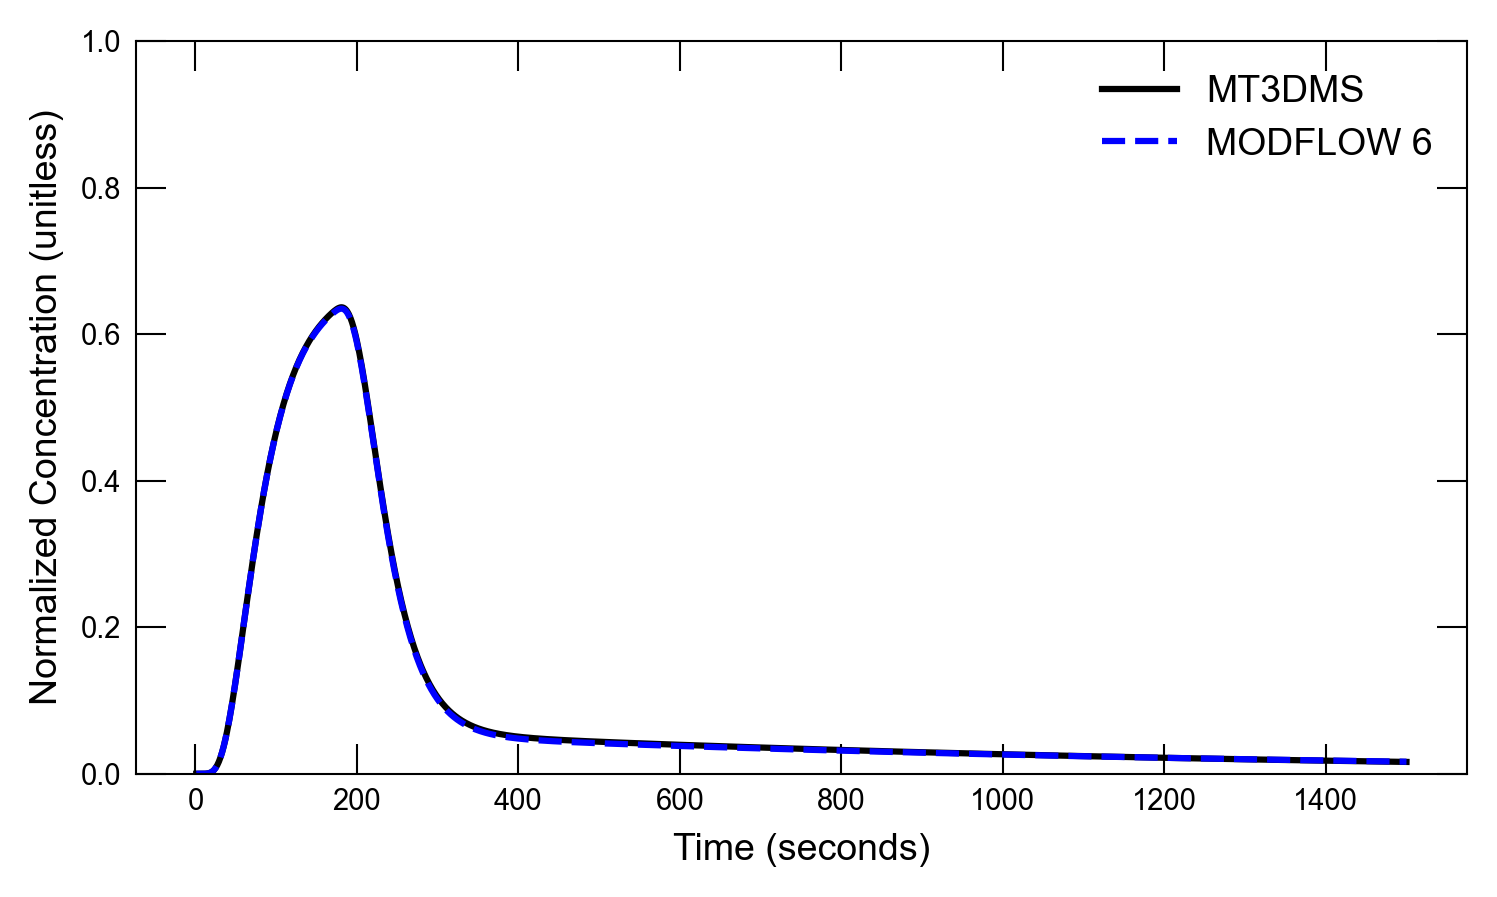

Building mf6gwf model...ex-gwt-mt3dms-p02e
Building mf6gwt model...ex-gwt-mt3dms-p02e
Building mf2005 model...ex-gwt-mt3dms-p02e
Building mt3dms model...ex-gwt-mt3dms-p02e


run_models took 2681.44 ms
Plotting C versus t model results...


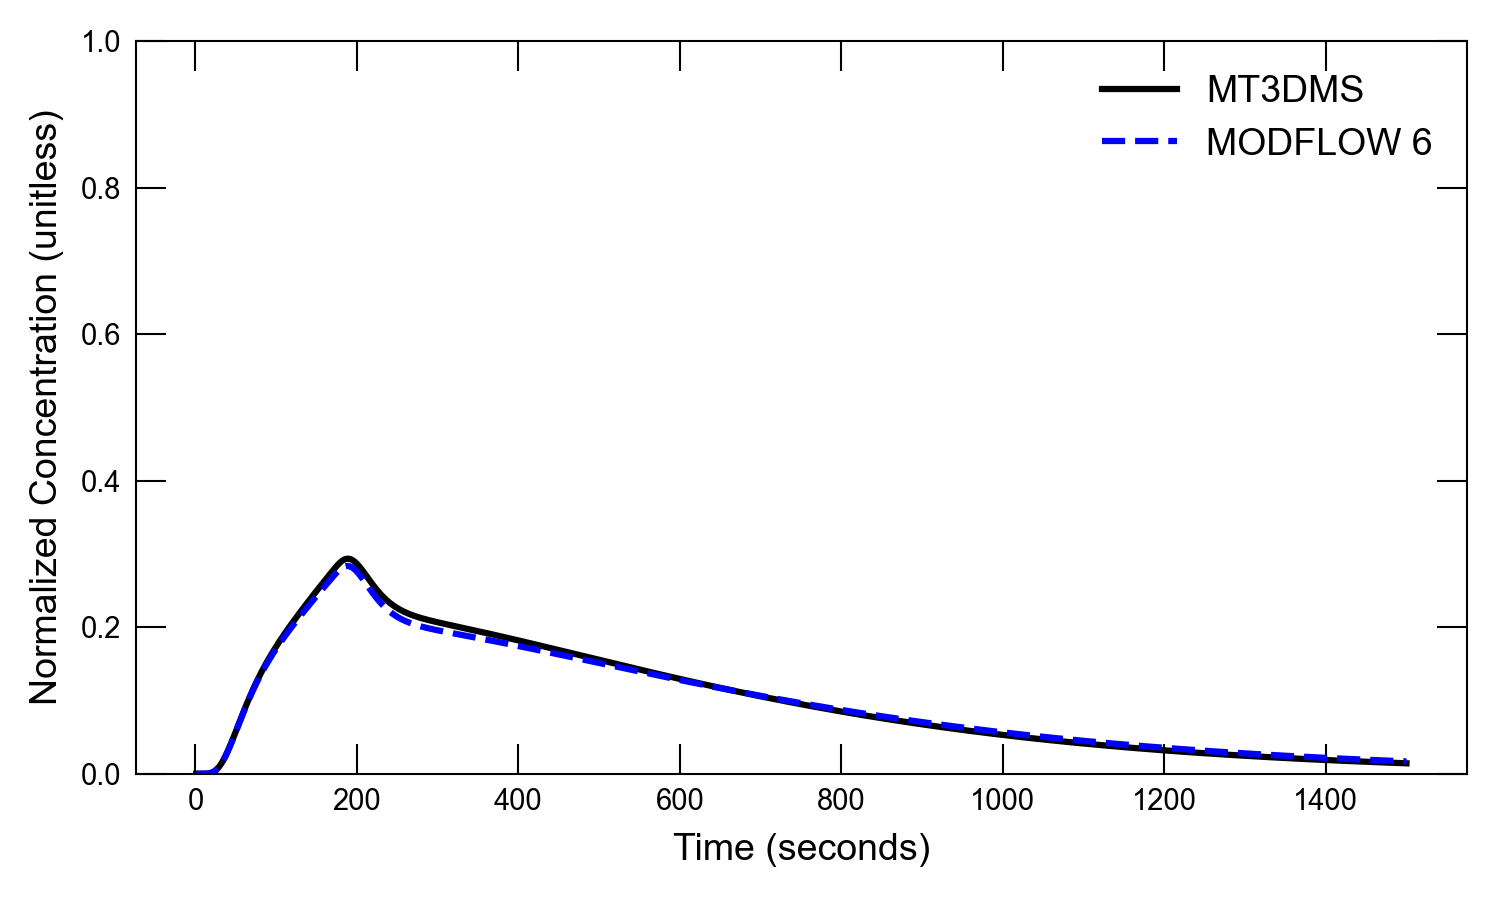

Building mf6gwf model...ex-gwt-mt3dms-p02f
Building mf6gwt model...ex-gwt-mt3dms-p02f
Building mf2005 model...ex-gwt-mt3dms-p02f
Building mt3dms model...ex-gwt-mt3dms-p02f


run_models took 2855.27 ms
Plotting C versus t model results...


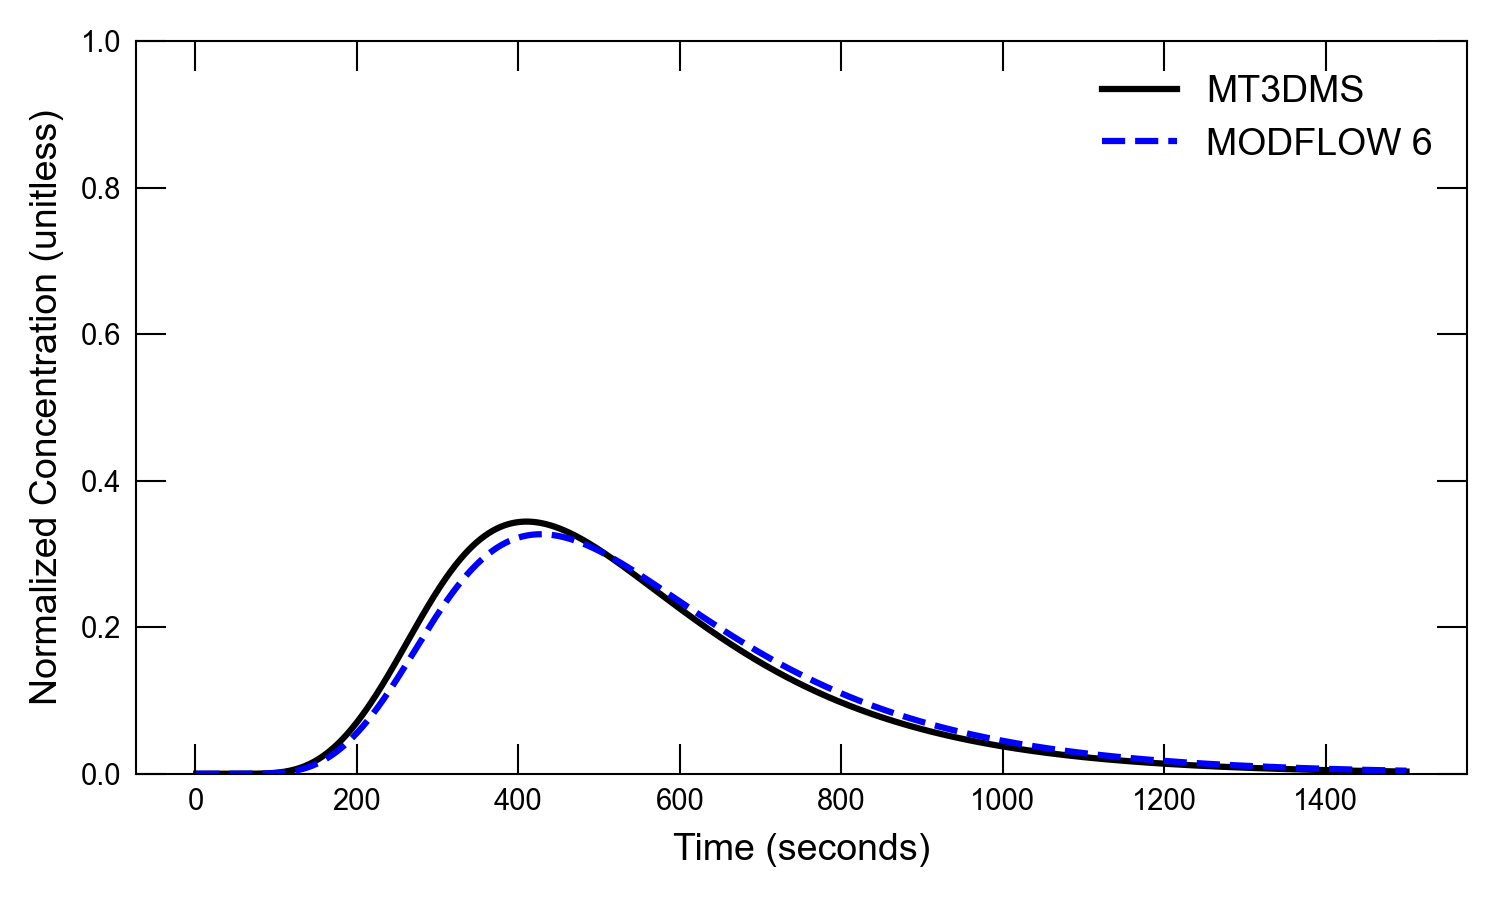

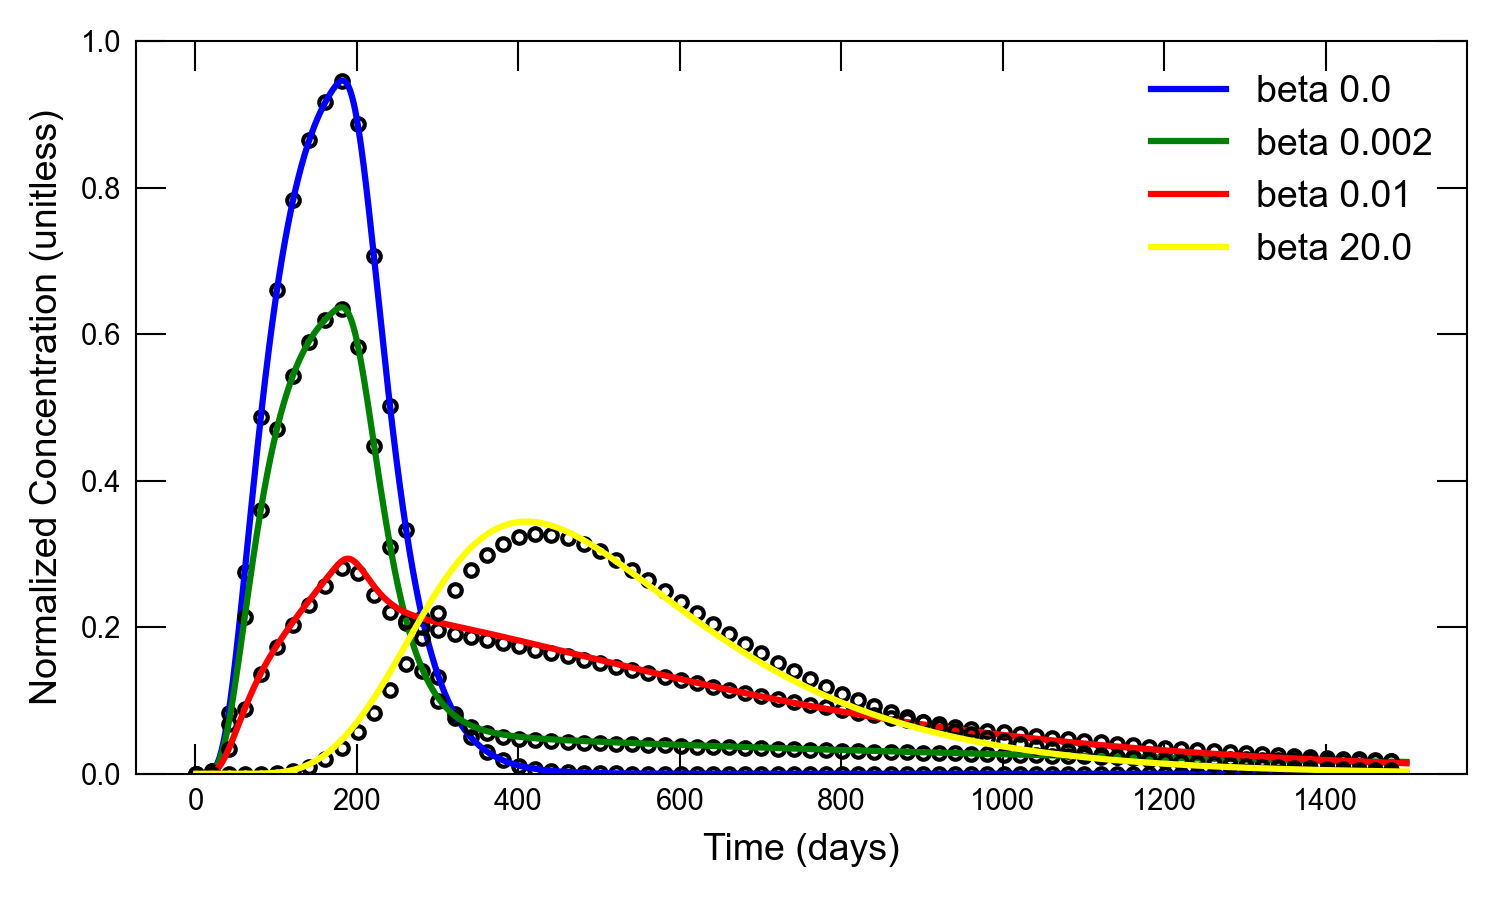

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    sims = build_models(key, **parameter_dict)
    if write:
        write_models(sims, silent=silent)
    if run:
        run_models(sims, silent=silent)
    if plot:
        plot_results_ct(sims, idx, **parameter_dict)


scenario(0)
scenario(1)
scenario(2)
scenario(3)
scenario(4)
scenario(5)

if plot:
    plot_results()